In [1]:
import numpy as np
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

input_dir = os.path.join("D:", 'input_data')
train_data_file = os.path.join(input_dir, 'train', 'data', 'data.csv')
train_labels_file = os.path.join(input_dir, 'train', 'labels', "data.labels")
train_settings_file = os.path.join(input_dir, 'train', 'settings', "data.json")
train_weights_file = os.path.join(input_dir, 'train', 'weights', "data.weights")

# read train data
data = pd.read_csv(train_data_file)

# read train labels
with open(train_labels_file, "r") as f:
    labels = np.array(f.read().splitlines(), dtype=float)

# read train settings
with open(train_settings_file) as f:
    settings = json.load(f)

# read train weights
with open(train_weights_file) as f:
    weights = np.array(f.read().splitlines(), dtype=float
                       )
    


In [14]:
print("data.shape: ", data.shape)
print("labels.shape: ", labels.shape)
print("weights.shape: ", weights.shape)


# split train data into train and test
train_data, test_data, train_labels, test_labels, train_weights, test_weights = train_test_split(data, labels, weights, test_size=0.2, random_state=42)

train_weights *= weights.sum()/train_weights.sum()
test_weights *= weights.sum()/test_weights.sum()

print("train_data.shape: ", train_data.shape)
print("train_labels.shape: ", train_labels.shape)
print("train_weights.shape: ", train_weights.shape)

gamma_roi = (train_weights*(train_labels)).sum()
beta_roi = (train_weights*(1-train_labels)).sum()

print("gamma_roi: ", gamma_roi)
print("beta_roi: ", beta_roi)


data.shape:  (2010001, 32)
labels.shape:  (2010001,)
weights.shape:  (2010001,)
train_data.shape:  (1608000, 32)
train_labels.shape:  (1608000,)
train_weights.shape:  (1608000,)
gamma_roi:  5307.531774967856
beta_roi:  1546821.155904455


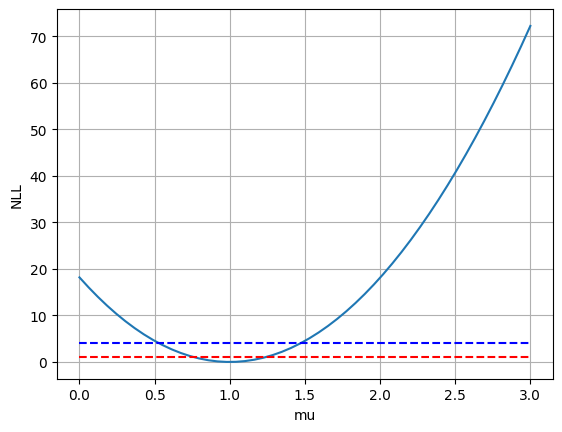

min NLL:  0.0
min NLL index:  16
min NLL mu:  0.9795918367346939
1 sigma:  1.2244897959183674 0.7959183673469388


In [31]:


def _sigma_asimov_SR(mu):
    return mu*gamma_roi + beta_roi
def _sigma_asimov_CR(mu):
    return 0

def calculate_NLL( mu_scan, weight_data,use_CR=False):
    sum_data_total_SR = weight_data.sum()
    sum_data_total_CR = 0
    comb_llr = []
    for i, mu in enumerate(mu_scan):
        hist_llr = (
            -2
            * sum_data_total_SR
            * np.log((_sigma_asimov_SR(mu) / _sigma_asimov_SR(1.0)))
        ) + (2 * (_sigma_asimov_SR(mu) - _sigma_asimov_SR(1.0)))

        if use_CR:
            hist_llr_CR = (
                -2
                * sum_data_total_CR
                * np.log((_sigma_asimov_CR(mu) / _sigma_asimov_CR(1.0)))
                ) + (2 * (_sigma_asimov_CR(mu) - _sigma_asimov_CR(1.0)))
        else:
            hist_llr_CR=0
            #print("do not use CR")    
        #DR time is spent here ?        


        comb_llr.append(hist_llr + hist_llr_CR)

    comb_llr = np.array(comb_llr)
    comb_llr = comb_llr - np.amin(comb_llr)

    return comb_llr

mu_scan = np.linspace(0, 3, 50)
hist_llr = calculate_NLL(mu_scan, test_weights)
hist_llr = np.array(hist_llr)

plt.plot( mu_scan,hist_llr)
plt.hlines(1, 0, 3, colors="r", linestyles="dashed")
plt.hlines(4, 0, 3, colors="b", linestyles="dashed")
plt.xlabel("mu")    
plt.ylabel("NLL")
plt.grid(True)
plt.show()

print("min NLL: ", min(hist_llr))
print("min NLL index: ", np.argmin(hist_llr))
print("min NLL mu: ", mu_scan[np.argmin(hist_llr)])

print("1 sigma: ", max(mu_scan[np.where((hist_llr < 1.0) & (hist_llr > 0.0))]), min(mu_scan[np.where((hist_llr < 1.0) & (hist_llr > 0.0))]))